In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn.functional as F
from tqdm import tqdm

from puzzle_utils import tch_divide_image
from dataset_builder import build_dataset

In [ ]:
class Config:
    def __init__(self):
        self.dataset = "MNIST"
        self.root = "./data"

cfg = Config()
dataset = build_dataset(cfg, split="train")

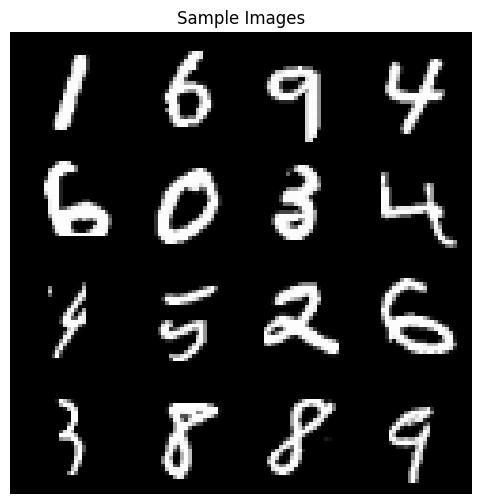

In [4]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))
img_grid = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(img_grid.permute(1, 2, 0))  # from CxHxW to HxWxC
plt.title("Sample Images")
plt.axis('off')
plt.show()

In [6]:
ones = [i for i in range(len(dataset)) if dataset.targets[i] == 1]
ones_dataset = Subset(dataset, ones)


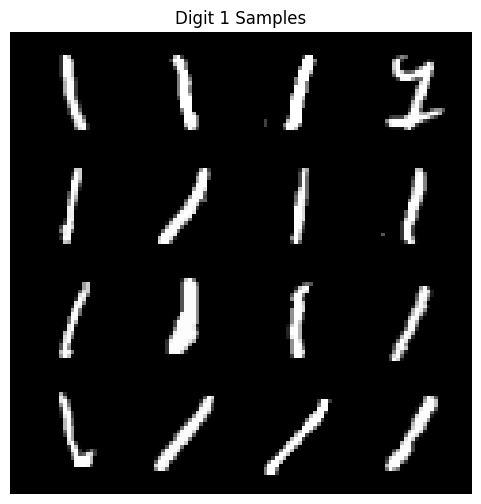

In [ ]:
ones_loader = DataLoader(ones_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(ones_loader))
img_grid = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(img_grid.permute(1, 2, 0), cmap='gray')
plt.title("Digit 1 Samples")
plt.axis('off')
plt.show()

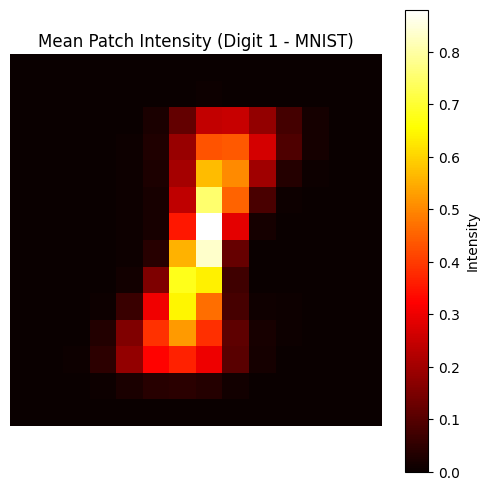

In [9]:
loader = DataLoader(ones_dataset, batch_size=64, shuffle=False)
patch_avg = torch.zeros((14, 14))
count = 0

for images, _ in loader:
    B = images.size(0)
    patches = images.unfold(2, 2, 2).unfold(3, 2, 2) 
    patch_means = patches.mean(dim=(-1, -2)).squeeze(1) 
    patch_avg += patch_means.sum(dim=0) 
    count += B

patch_avg /= count 
plt.figure(figsize=(6, 6))
plt.imshow(patch_avg.numpy(), cmap='hot', interpolation='nearest')
plt.title("Mean Patch Intensity (Digit 1 - MNIST)")
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

In [10]:
flat_avg = patch_avg.flatten() 
sorted_indices = torch.argsort(flat_avg, descending=True)
print("Patches sorted by average intensity (high to low):")
for rank, idx in enumerate(sorted_indices.tolist()):
    row = idx // 14
    col = idx % 14
    intensity = flat_avg[idx].item()
    print(f"Rank {rank+1}: Patch #{idx} (row={row}, col={col}) -> Mean intensity = {intensity:.4f}")


Patches sorted by average intensity (high to low):
Rank 1: Patch #91 (row=6, col=7) -> Mean intensity = 0.8811
Rank 2: Patch #105 (row=7, col=7) -> Mean intensity = 0.8333
Rank 3: Patch #77 (row=5, col=7) -> Mean intensity = 0.7520
Rank 4: Patch #118 (row=8, col=6) -> Mean intensity = 0.6801
Rank 5: Patch #132 (row=9, col=6) -> Mean intensity = 0.6451
Rank 6: Patch #119 (row=8, col=7) -> Mean intensity = 0.6394
Rank 7: Patch #63 (row=4, col=7) -> Mean intensity = 0.5687
Rank 8: Patch #104 (row=7, col=6) -> Mean intensity = 0.5559
Rank 9: Patch #146 (row=10, col=6) -> Mean intensity = 0.5257
Rank 10: Patch #64 (row=4, col=8) -> Mean intensity = 0.5028
Rank 11: Patch #133 (row=9, col=7) -> Mean intensity = 0.4651
Rank 12: Patch #78 (row=5, col=8) -> Mean intensity = 0.4530
Rank 13: Patch #50 (row=3, col=8) -> Mean intensity = 0.4403
Rank 14: Patch #49 (row=3, col=7) -> Mean intensity = 0.4326
Rank 15: Patch #145 (row=10, col=5) -> Mean intensity = 0.3866
Rank 16: Patch #147 (row=10, col=

L1 Loss: 0.0811
L2 Loss: 0.0615


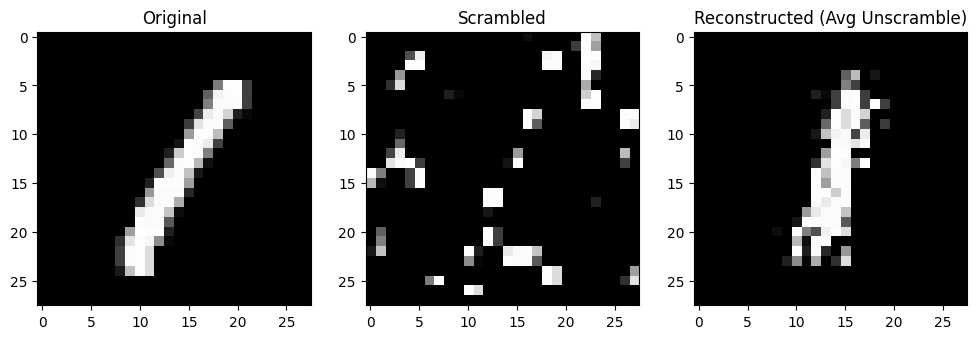

In [13]:
num_pieces = 14
reference_order = torch.argsort(patch_avg.flatten(), descending=True)

image, _ = ones_dataset[0] 
original_image = image.clone()

pieces, random_pieces, permute_index = tch_divide_image(image, num_pieces)
means = random_pieces.view(random_pieces.size(0), -1).mean(dim=1)
predicted_order = torch.argsort(means, descending=True)
reconstructed_pieces = torch.zeros_like(random_pieces)
for i in range(num_pieces**2):
    reconstructed_pieces[reference_order[i]] = random_pieces[predicted_order[i]]

def stitch_image(patches, num_pieces):
    rows = []
    for i in range(num_pieces):
        row = torch.cat([patches[i * num_pieces + j] for j in range(num_pieces)], dim=2)
        rows.append(row)
    return torch.cat(rows, dim=1)

reconstructed_image = stitch_image(reconstructed_pieces, num_pieces)


l1 = F.l1_loss(reconstructed_image, original_image)
l2 = F.mse_loss(reconstructed_image, original_image)

print(f"L1 Loss: {l1.item():.4f}")
print(f"L2 Loss: {l2.item():.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(stitch_image(random_pieces, num_pieces).squeeze(), cmap='gray')
plt.title("Scrambled")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.squeeze(), cmap='gray')
plt.title("Reconstructed (Avg Unscramble)")

plt.show()

In [14]:
def stitch_image(patches, num_pieces):
    rows = []
    for i in range(num_pieces):
        row = torch.cat([patches[i * num_pieces + j] for j in range(num_pieces)], dim=2)
        rows.append(row)
    return torch.cat(rows, dim=1)

In [17]:
num_pieces = 14
patch_size = 28 // num_pieces
total_patches = num_pieces * num_pieces
total_l1, total_l2 = 0.0, 0.0
num_samples = 1000 

for i in tqdm(range(num_samples)):
    image, _ = ones_dataset[i]
    original_image = image.clone()
    pieces, random_pieces, _ = tch_divide_image(image, num_pieces)
    means = random_pieces.view(random_pieces.size(0), -1).mean(dim=1)
    predicted_order = torch.argsort(means, descending=True)
    reconstructed_pieces = torch.zeros_like(random_pieces)
    for j in range(total_patches):
        reconstructed_pieces[reference_order[j]] = random_pieces[predicted_order[j]]
    reconstructed_image = stitch_image(reconstructed_pieces, num_pieces)
    l1 = F.l1_loss(reconstructed_image, original_image)
    l2 = F.mse_loss(reconstructed_image, original_image)

    total_l1 += l1.item()
    total_l2 += l2.item()

avg_l1 = total_l1 / num_samples
avg_l2 = total_l2 / num_samples
print(f"\nAverage L1 Loss over {num_samples} samples: {avg_l1:.4f}")
print(f"Average L2 Loss over {num_samples} samples: {avg_l2:.4f}")

100%|██████████| 1000/1000 [00:01<00:00, 681.43it/s]


Average L1 Loss over 1000 samples: 0.0613
Average L2 Loss over 1000 samples: 0.0444


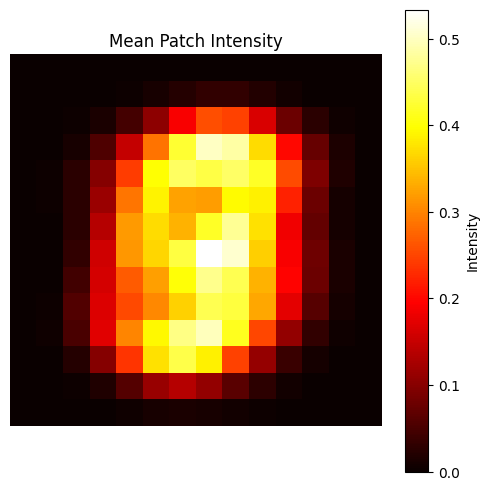

In [19]:
loader = DataLoader(dataset, batch_size=64, shuffle=False)
patch_avg = torch.zeros((14, 14))
count = 0

for images, _ in loader:
    B = images.size(0)
    patches = images.unfold(2, 2, 2).unfold(3, 2, 2) 
    patch_means = patches.mean(dim=(-1, -2)).squeeze(1) 
    patch_avg += patch_means.sum(dim=0) 
    count += B

patch_avg /= count 
plt.figure(figsize=(6, 6))
plt.imshow(patch_avg.numpy(), cmap='hot', interpolation='nearest')
plt.title("Mean Patch Intensity")
plt.colorbar(label='Intensity')
plt.axis('off')
plt.show()

In [20]:
flat_avg = patch_avg.flatten() 
sorted_indices = torch.argsort(flat_avg, descending=True)
print("Patches sorted by average intensity (high to low):")
for rank, idx in enumerate(sorted_indices.tolist()):
    row = idx // 14
    col = idx % 14
    intensity = flat_avg[idx].item()
    print(f"Rank {rank+1}: Patch #{idx} (row={row}, col={col}) -> Mean intensity = {intensity:.4f}")

Patches sorted by average intensity (high to low):
Rank 1: Patch #105 (row=7, col=7) -> Mean intensity = 0.5339
Rank 2: Patch #106 (row=7, col=8) -> Mean intensity = 0.5083
Rank 3: Patch #49 (row=3, col=7) -> Mean intensity = 0.5007
Rank 4: Patch #147 (row=10, col=7) -> Mean intensity = 0.4973
Rank 5: Patch #50 (row=3, col=8) -> Mean intensity = 0.4841
Rank 6: Patch #92 (row=6, col=8) -> Mean intensity = 0.4775
Rank 7: Patch #119 (row=8, col=7) -> Mean intensity = 0.4725
Rank 8: Patch #146 (row=10, col=6) -> Mean intensity = 0.4677
Rank 9: Patch #64 (row=4, col=8) -> Mean intensity = 0.4511
Rank 10: Patch #62 (row=4, col=6) -> Mean intensity = 0.4492
Rank 11: Patch #120 (row=8, col=8) -> Mean intensity = 0.4402
Rank 12: Patch #133 (row=9, col=7) -> Mean intensity = 0.4402
Rank 13: Patch #160 (row=11, col=6) -> Mean intensity = 0.4379
Rank 14: Patch #63 (row=4, col=7) -> Mean intensity = 0.4351
Rank 15: Patch #104 (row=7, col=6) -> Mean intensity = 0.4328
Rank 16: Patch #134 (row=9, col

L1 Loss: 0.1296
L2 Loss: 0.0958


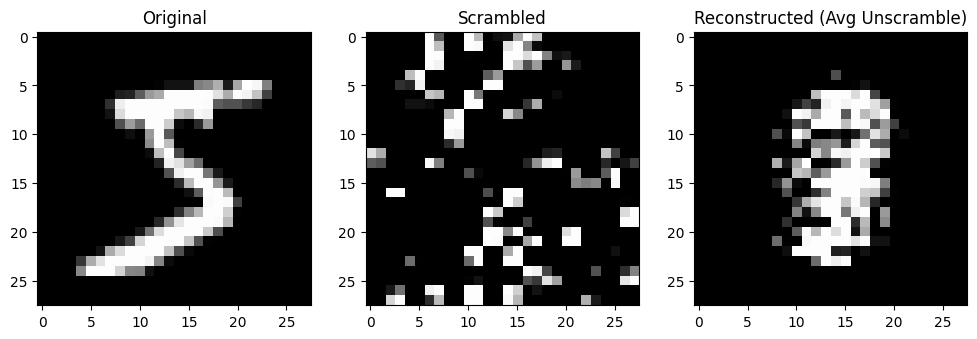

In [21]:
num_pieces = 14
reference_order = torch.argsort(patch_avg.flatten(), descending=True)

image, _ = dataset[0] 
original_image = image.clone()

pieces, random_pieces, permute_index = tch_divide_image(image, num_pieces)
means = random_pieces.view(random_pieces.size(0), -1).mean(dim=1)
predicted_order = torch.argsort(means, descending=True)
reconstructed_pieces = torch.zeros_like(random_pieces)
for i in range(num_pieces**2):
    reconstructed_pieces[reference_order[i]] = random_pieces[predicted_order[i]]

def stitch_image(patches, num_pieces):
    rows = []
    for i in range(num_pieces):
        row = torch.cat([patches[i * num_pieces + j] for j in range(num_pieces)], dim=2)
        rows.append(row)
    return torch.cat(rows, dim=1)

reconstructed_image = stitch_image(reconstructed_pieces, num_pieces)


l1 = F.l1_loss(reconstructed_image, original_image)
l2 = F.mse_loss(reconstructed_image, original_image)

print(f"L1 Loss: {l1.item():.4f}")
print(f"L2 Loss: {l2.item():.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(stitch_image(random_pieces, num_pieces).squeeze(), cmap='gray')
plt.title("Scrambled")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.squeeze(), cmap='gray')
plt.title("Reconstructed (Avg Unscramble)")

plt.show()

In [23]:
num_pieces = 14
patch_size = 28 // num_pieces
total_patches = num_pieces * num_pieces
total_l1, total_l2 = 0.0, 0.0
num_samples = 10000 

for i in tqdm(range(num_samples)):
    image, _ = dataset[i]
    original_image = image.clone()
    pieces, random_pieces, _ = tch_divide_image(image, num_pieces)
    means = random_pieces.view(random_pieces.size(0), -1).mean(dim=1)
    predicted_order = torch.argsort(means, descending=True)
    reconstructed_pieces = torch.zeros_like(random_pieces)
    for j in range(total_patches):
        reconstructed_pieces[reference_order[j]] = random_pieces[predicted_order[j]]
    reconstructed_image = stitch_image(reconstructed_pieces, num_pieces)
    l1 = F.l1_loss(reconstructed_image, original_image)
    l2 = F.mse_loss(reconstructed_image, original_image)

    total_l1 += l1.item()
    total_l2 += l2.item()

avg_l1 = total_l1 / num_samples
avg_l2 = total_l2 / num_samples
print(f"\nAverage L1 Loss over {num_samples} samples: {avg_l1:.4f}")
print(f"Average L2 Loss over {num_samples} samples: {avg_l2:.4f}")

100%|██████████| 10000/10000 [00:14<00:00, 682.82it/s]


Average L1 Loss over 10000 samples: 0.1341
Average L2 Loss over 10000 samples: 0.1038
